In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [2]:
pd.set_option('display.max_rows', None)

data = pd.read_csv('../data/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
quantitative = [f for f in data.columns if data.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in data.columns if data.dtypes[f] == 'object']
quantitative.remove("MSSubClass")
qualitative.append("MSSubClass")

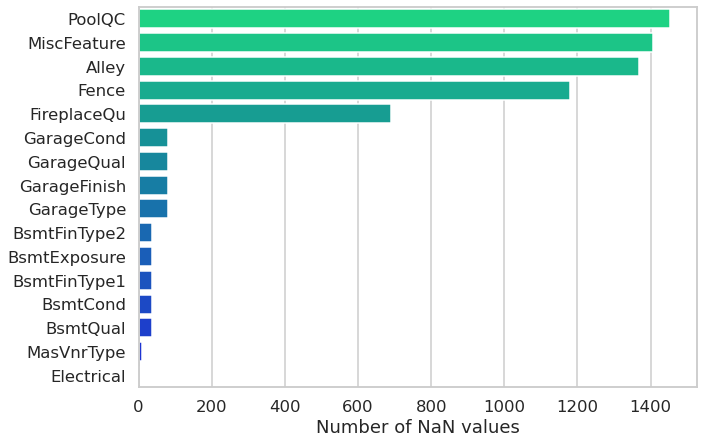

In [4]:
def missing(columns):
    missing = data[columns].isnull().sum()
    missing = missing[missing > 0]
    missing.sort_values(ascending=False, inplace=True)
    return missing

def plot_nan(data):
    sns.set_theme(style="whitegrid", context="talk")
    f, ax1 = plt.subplots(1, 1, figsize=(10, 7))
    sns.barplot(x=data.values, y=data.index, palette="winter_r", ax=ax1, orient="h")
    sns.set(font_scale=2)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)
    ax1.set_xlabel("Number of NaN values")

qual_miss = missing(qualitative)
plot_nan(qual_miss)

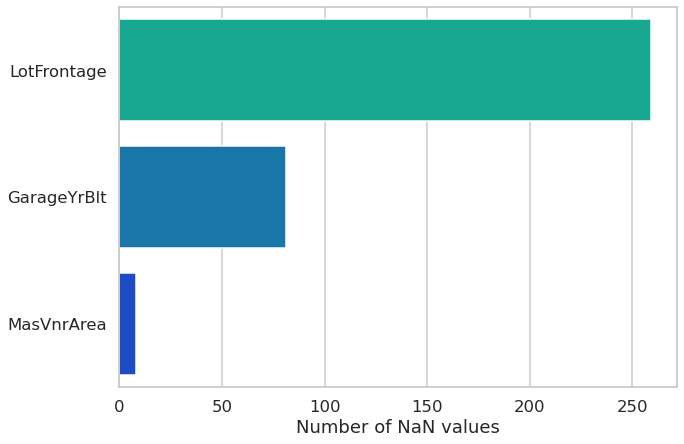

In [5]:
quan_miss = missing(quantitative)
plot_nan(quan_miss)

The data description for:
 - **PoolQ**
 - **MiscFeature**
 - **Alley**
 - **Fence**
 - **FireplaceQu**
 - **GarageCond**
 - **GarageQual**
 - **GarageFinish**
 - **GarageType**
 - **BsmtFinType2**
 - **BsmtExposure**
 - **BsmtFinType1**
 - **BsmtCond**
 - **BsmtQual** 

Says clearly that the NaN values stand for No Pool, No alley access, No Garage and so on. Because of that we are going to substitute all NaN in those categorical atributes for "None". Besides that, there is a NaN value in **MasVnrType**, and e will substitute for "None" too, seeing that this class already exist.

Also, the one record that has a NaN in the **Electrical** atribute, will be droped, because one record will not affect the regression algorithms.

Finally, the NaN values in the **LotFrontage**, **GarageYrBlt** and **MasVnrArea** will be set to zero.

In [6]:
data.dropna(subset=['Electrical'], inplace=True)
for atribute in qualitative:
    data[atribute] = data[atribute].fillna('None')
    
for atribute in quantitative:
    data[atribute] = data[atribute].fillna(0)

**CentralAir** has no need for one-hot encoding

The atributes **GarageType**, **GarageFinish**, **GarageQual**, and **GarageCond** will each generate the "None" column after one-hot encoding, all of them must be droped, except one, since they all will be equal.

The same goes to **BsmtCond**, **BsmtExposure**, **BsmtQual** (but have to pay attention to **BsmtFinType2** and **BsmtFinType1** to see their relationship)